In [25]:
#import relevant libraries
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense,Flatten,Reshape,Lambda,Embedding,multiply,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K 
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers.merge import concatenate as concat

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()#load in the MNIST data

In [27]:
#normalise the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [28]:
#put everythong in the correct shape
n_pixels = np.prod(x_train.shape[1:])
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [29]:
#convert to categorical data type
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [30]:
train = np.concatenate([x_train,y_train],axis = -1) #put the features and labels in one
pixels = np.prod(train.shape[1:])

In [32]:
#cGAN

In [33]:
codings_size = 100 #choose the size of encodings
num_classes = 10 #number of labels

In [34]:
#Create the generator
generator = Sequential([
    Dense(100, activation = 'selu', input_shape = [codings_size]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(150, activation = 'selu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(n_pixels, activation = 'sigmoid')
])


In [35]:
#Create the discriminator
disc = Sequential([
    Dense(250, activation='selu', input_shape=[n_pixels]),
    Dense(200,activation = 'selu'),
    Dense(150,activation = 'selu'),
    Dense(100,activation = 'selu'),
    Dense(1, activation = 'sigmoid')
])


In [36]:
#link uo the cGAN
gan = Sequential([generator,disc])

In [37]:
disc.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')#loss of the discriminator
disc.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')#loss of the generator

In [38]:
batch_size = 32 #define a batch
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000) #create a tf.dataset using the traiing data and shuffle
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [39]:
#A function to train the cGAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=100):
    generator, disc = gan.layers
    for epoch in range(n_epochs):
        for batch in dataset:
            #step 1: train the discriminatoe 
            noise = tf.random.normal(shape = [batch_size, codings_size]) #create random noise
            generated_images = generator(noise) #feed it to the generator
            X_fake_and_real = tf.concat([generated_images, batch], axis = 0)#concatenate real data with the generated data
            y1 = tf.constant([[0.]]*batch_size+[[1.]]*batch_size) #make the labels
            disc.trainable = True
            disc.train_on_batch(X_fake_and_real, y1) #train the discriminator
            
            #step 2: train the generator
            noise = tf.random.normal(shape = [batch_size, codings_size]) #create random noise
            y2 = tf.constant([[1.]] * batch_size) #set labels as real
            disc.trainable = False
            gan.train_on_batch(noise,y2) #train the generator
        if epoch%10 == 0: #after every 10th epoch display a number of choice
            print('Epoch: '+str(epoch+1)+':')
            n = 10
            labels = np.array([[1,0,0,0,0,0,0,0,0,0]*n])
            labels=labels.reshape(n,10)
            new_codings = tf.random.normal(shape=[n,codings_size])
            numbers = generator(np.concatenate([new_codings],axis=-1)).numpy()
            plt.figure(figsize=(20, 4))
            for i in range(1,n):
                # display reconstruction
                ax = plt.subplot(2, n, i + n)
                plt.imshow(numbers[i].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.show()

Epoch: 1:


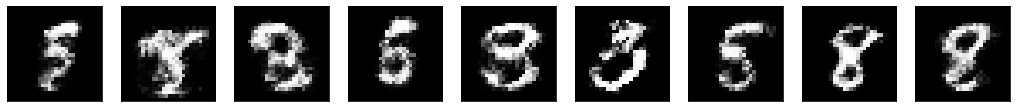

KeyboardInterrupt: 

In [40]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
#make cGAN write a number of choice
n = 10
labels = np.array([[1,0,0,0,0,0,0,0,0,0]*n])
labels=labels.reshape(n,10)
new_codings = tf.random.normal(shape=[n,codings_size])
numbers = generator(np.concatenate([new_codings],axis=-1)).numpy()
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(numbers[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()